In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date, time, datetime
from xgboost.sklearn import XGBClassifier


In [11]:
train_users = pd.read_csv(r"C:\Users\Ben\Desktop\Project3_DS_310\train_users.csv",parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
test_users = pd.read_csv(r"C:\Users\Ben\Desktop\Project3_DS_310\test_users.csv",parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
sessions = pd.read_csv(r"C:\Users\Ben\Desktop\Project3_DS_310\sessions.csv")

In [12]:
Y = train_users['country_destination'] # these are our labels
train_users = train_users.drop('country_destination', axis =1)

In [13]:

train_users.columns # exploratory

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')

In [14]:
df_all = pd.concat((train_users, test_users), axis = 0, ignore_index= True)

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Splitting date time data for date account created
df_all['dac_year'] = df_all.date_account_created.dt.year
df_all['dac_month'] = df_all.date_account_created.dt.month
df_all['dac_day'] = df_all.date_account_created.dt.day
df_all["dac_day_of_week"] = df_all.date_account_created.dt.dayofweek

# Splitting date time data for time first active
df_all['tfa_year'] = df_all.timestamp_first_active.dt.year
df_all['tfa_month'] = df_all.timestamp_first_active.dt.month
df_all['tfa_day'] = df_all.timestamp_first_active.dt.day
df_all['tfa_day_of_week'] = df_all.timestamp_first_active.dt.dayofweek

In [16]:
df_all.drop('date_account_created',1, inplace=True)
df_all.drop('timestamp_first_active',1, inplace=True)

In [17]:
df_all

,id,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,first_device_type,first_browser,dac_year,dac_month,dac_day,dac_day_of_week,tfa_year,tfa_month,tfa_day,tfa_day_of_week
0,gxn3p5htnn,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,...,Mac Desktop,Chrome,2010,6,28,0,2009,3,19,3
1,820tgsjxq7,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,...,Mac Desktop,Chrome,2011,5,25,2,2009,5,23,5
2,4ft3gnwmtx,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,...,Windows Desktop,IE,2010,9,28,1,2009,6,9,1
3,bjjt8pjhuk,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,...,Mac Desktop,Firefox,2011,12,5,0,2009,10,31,5
4,87mebub9p4,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,...,Mac Desktop,Chrome,2010,9,14,1,2009,12,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,cv0na2lf5a,NaT,-unknown-,31.0,basic,0,en,direct,direct,untracked,...,Windows Desktop,IE,2014,9,30,1,2014,9,30,1
275543,zp8xfonng8,NaT,-unknown-,NaN,basic,23,ko,direct,direct,untracked,...,Android Phone,-unknown-,2014,9,30,1,2014,9,30,1
275544,fa6260ziny,NaT,-unknown-,NaN,basic,0,de,direct,direct,linked,...,Windows Desktop,Firefox,2014,9,30,1,2014,9,30,1
275545,87k0fy4ugm,NaT,-unknown-,NaN,basic,0,en,sem-brand,google,omg,...,Mac Desktop,Safari,2014,9,30,1,2014,9,30,1


In [18]:
#df_all.loc[df_all.age > 100, 'age'] = np.nan
#df_all.loc[df_all.age < 18, 'age'] = np.nan

age_values = df_all.age.values
df_all['age'] = np.where(age_values>1000, np.random.randint(28, 43), age_values)
df_all['age'] = df_all['age'].fillna(np.random.randint(28, 43))

In [19]:
by_signup_device = df_all.groupby(['signup_method', 'first_device_type'])
def impute_median(series):
    return series.fillna(series.median())
df_all.age = by_signup_device['age'].transform(impute_median)

In [20]:
tracked = []

for i in df_all['first_affiliate_tracked']:
    if i == "untracked" or i == "":
        isTracked = 0
    else:
        isTracked = 1
    tracked.append(isTracked)

df_all['is_first_affiliate_tracked'] = tracked

In [21]:
seconds = sessions.groupby('user_id', as_index=False).agg({"secs_elapsed": "sum"})
df_all = pd.merge(df_all, seconds, left_on="id", right_on="user_id", how="left")
df_all['secs_elapsed'] = df_all['secs_elapsed'].fillna(0)

In [22]:
method = pd.get_dummies(df_all[["signup_method"]])
affch = pd.get_dummies(df_all[["affiliate_channel"]])
affprov = pd.get_dummies(df_all[["affiliate_provider"]])
firstdevice = pd.get_dummies(df_all[["first_device_type"]])
signupFlow = pd.get_dummies(df_all[["signup_flow"]].astype(str))
signup = pd.get_dummies(df_all[["signup_app"]])
genderdum = pd.get_dummies(df_all[["gender"]])
langdum = pd.get_dummies(df_all[["language"]])
browser = pd.get_dummies(df_all[["first_browser"]])

df2 = df_all

df2 = pd.concat([df2.reset_index(drop=True),method.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),affch.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),affprov.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),firstdevice.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),signupFlow.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),genderdum.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),signup.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),langdum.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),browser.reset_index(drop=True)], axis=1)

In [23]:
df2 = df2.drop(['id',  'date_first_booking','gender', 
          'signup_method',  'affiliate_channel', 'affiliate_provider', 'first_device_type', 
          'first_browser', 'signup_app', 'first_browser'], axis=1)

In [24]:
df2 = df2.drop("language", axis=1)

In [25]:
df2 = df2.drop('signup_flow', axis=1)
df2 = df2.drop(['first_affiliate_tracked'], axis=1)

In [26]:
id_test = test_users['id']

In [27]:
print(len(Y.unique()))
print(Y.unique())

12
['NDF' 'US' 'other' 'FR' 'CA' 'GB' 'ES' 'IT' 'PT' 'NL' 'DE' 'AU']


In [28]:
print(df2.shape)
print(len(Y))
#print(train.shape)
print(df_all.shape)

(275547, 158)
213451
(275547, 24)


In [42]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275547 entries, 0 to 275546
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          275547 non-null  object        
 1   date_first_booking          88908 non-null   datetime64[ns]
 2   gender                      275547 non-null  object        
 3   age                         275547 non-null  float64       
 4   signup_method               275547 non-null  object        
 5   signup_flow                 275547 non-null  int64         
 6   language                    275547 non-null  object        
 7   affiliate_channel           275547 non-null  object        
 8   affiliate_provider          275547 non-null  object        
 9   first_affiliate_tracked     269462 non-null  object        
 10  signup_app                  275547 non-null  object        
 11  first_device_type           275547 non-

In [43]:
df2 = df2.drop("user_id", axis = 1)

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection



#Y = train_users['country_destination'] # these are our labels
#train_users = train_users.drop('country_destination', axis =1)



train = df2.iloc[0:len(train_users),:]
test = df2.iloc[len(train_users):,:]


X_train, X_test, y_train, y_test = model_selection.train_test_split(
    train, Y, test_size=0.33, random_state=42)


#train_users_n = train_users.shape[0] # comment
#X_train = df2.values[:train_users_n] # comment
le = LabelEncoder() # don't uncommment
#y_train = le.fit_transform(Y)

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)   


#X_test = df2.values[train_users_n:]


def generate_answer(y_pred, classifer_name):
    #Taking the 5 classes with highest probabilities
    ids = []  #list of ids
    cts = []  #list of countries
    for i in range(len(id_test)):
        idx = id_test[i]
        ids += [idx] * 12
        cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:12].tolist()
    
    sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
    sub.to_csv(classifer_name+'.csv',index=False)
    return sub

In [ ]:
len(y_train)
len(X_train)
len(X_test)

In [45]:
train.head()

,age,dac_year,dac_month,dac_day,dac_day_of_week,tfa_year,tfa_month,tfa_day,tfa_day_of_week,is_first_affiliate_tracked,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,34.0,2010,6,28,0,2009,3,19,3,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,2011,5,25,2,2009,5,23,5,0,...,0,0,0,0,0,0,0,0,0,0
2,56.0,2010,9,28,1,2009,6,9,1,0,...,0,0,0,0,0,0,0,0,0,0
3,42.0,2011,12,5,0,2009,10,31,5,0,...,0,0,0,0,0,0,0,0,0,0
4,41.0,2010,9,14,1,2009,12,8,1,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:

xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict_proba(X_test)

KeyboardInterrupt: 

In [96]:

xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0, nthread = -1)                  
xgb.fit(train, Y)
#Y_predict = xgb.predict_proba(train)

XGBClassifier(colsample_bytree=0.5, learning_rate=0.3, max_depth=6,
              n_estimators=25, nthread=-1, objective='multi:softprob', seed=0,
              subsample=0.5)

In [67]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

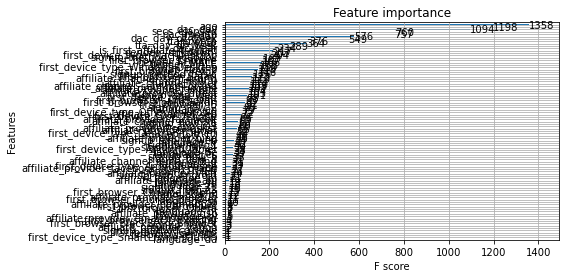

In [97]:
plot_importance(xgb)
pyplot.show()

In [72]:
importance = xgb.feature_importances_
importance_df = pd.DataFrame(importance, index=X_train.columns, 
                      columns=["Importance"])

In [84]:
importance_df = importance_df.sort_values(by = ['Importance'], ascending = False)

In [86]:
importance_df.to_csv('importance3.csv')

In [87]:
trim = importance_df[importance_df.Importance > 0]

In [94]:
trim.to_csv('trim.csv')

In [90]:
indexNamesArr = trim.index.values
listoftrim = list(indexNamesArr)

In [95]:
train = train[listoftrim]
test = test[listoftrim]

In [102]:
print(listoftrim)

['gender_-unknown-', 'signup_method_facebook', 'age', 'affiliate_channel_content', 'first_browser_-unknown-', 'signup_app_Android', 'signup_app_iOS', 'signup_flow_1', 'signup_method_basic', 'first_device_type_Other/Unknown', 'gender_MALE', 'signup_app_Web', 'signup_flow_2', 'language_en', 'tfa_year', 'signup_flow_3', 'signup_flow_0', 'signup_app_Moweb', 'affiliate_channel_direct', 'first_device_type_Mac Desktop', 'signup_flow_25', 'is_first_affiliate_tracked', 'affiliate_provider_meetup', 'affiliate_provider_facebook', 'secs_elapsed', 'gender_FEMALE', 'affiliate_channel_sem-non-brand', 'signup_flow_12', 'dac_year', 'affiliate_channel_other', 'first_device_type_Android Phone', 'affiliate_provider_other', 'first_browser_Chrome', 'first_device_type_SmartPhone (Other)', 'first_browser_AOL Explorer', 'signup_flow_24', 'signup_flow_5', 'affiliate_channel_api', 'first_browser_Firefox', 'language_ko', 'language_it', 'language_zh', 'affiliate_provider_craigslist', 'first_browser_Camino', 'affil

In [103]:
'''
['gender_-unknown-', 'signup_method_facebook', 'age', 'affiliate_channel_content', 'first_browser_-unknown-', 'signup_app_Android', 'signup_app_iOS', 'signup_flow_1', 'signup_method_basic', 'first_device_type_Other/Unknown', 'gender_MALE', 'signup_app_Web', 'signup_flow_2', 'language_en', 'tfa_year', 'signup_flow_3', 'signup_flow_0', 'signup_app_Moweb', 'affiliate_channel_direct', 'first_device_type_Mac Desktop', 'signup_flow_25', 'is_first_affiliate_tracked', 'affiliate_provider_meetup', 'affiliate_provider_facebook', 'secs_elapsed', 'gender_FEMALE', 'affiliate_channel_sem-non-brand', 'signup_flow_12', 'dac_year', 'affiliate_channel_other', 'first_device_type_Android Phone', 'affiliate_provider_other', 'first_browser_Chrome', 'first_device_type_SmartPhone (Other)', 'first_browser_AOL Explorer', 'signup_flow_24', 'signup_flow_5', 'affiliate_channel_api', 'first_browser_Firefox', 'language_ko', 'language_it', 'language_zh', 'affiliate_provider_craigslist', 'first_browser_Camino', 'affiliate_provider_vast', 'first_browser_Silk', 'language_ja', 'signup_flow_8', 'language_fi', 'language_fr', 'dac_month', 'first_device_type_Windows Desktop', 'affiliate_channel_seo', 'tfa_month', 'first_device_type_iPhone', 'first_browser_IE', 'first_browser_Android Browser', 'affiliate_channel_remarketing', 'language_es', 'language_da', 'first_browser_Mobile Safari', 'language_de', 'first_browser_Safari', 'affiliate_provider_google', 'affiliate_provider_facebook-open-graph', 'first_browser_Chrome Mobile', 'affiliate_provider_padmapper', 'signup_flow_23', 'signup_flow_21', 'affiliate_provider_direct', 'affiliate_channel_sem-brand', 'first_device_type_iPad', 'language_pt', 'dac_day', 'first_browser_Chromium', 'gender_OTHER', 'dac_day_of_week', 'tfa_day', 'affiliate_provider_bing', 'tfa_day_of_week', 'language_ru', 'first_device_type_Desktop (Other)', 'affiliate_provider_yahoo', 'affiliate_provider_gsp', 'first_device_type_Android Tablet', 'first_browser_Opera', 'signup_flow_6', 'affiliate_provider_email-marketing', 'language_nl', 'language_sv', 'signup_method_google', 'first_browser_BlackBerry Browser']
trim list 
''''''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-103-dafd67b08f65>, line 4)

In [92]:
train

,gender_-unknown-,signup_method_facebook,age,affiliate_channel_content,first_browser_-unknown-,signup_app_Android,signup_app_iOS,signup_flow_1,signup_method_basic,first_device_type_Other/Unknown,...,affiliate_provider_yahoo,affiliate_provider_gsp,first_device_type_Android Tablet,first_browser_Opera,signup_flow_6,affiliate_provider_email-marketing,language_nl,language_sv,signup_method_google,first_browser_BlackBerry Browser
0,1,1,34.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,38.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,56.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,42.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,41.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,0,0,32.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
213447,1,0,34.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
213448,1,0,32.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
213449,1,0,34.0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
Y_Predict = xgb.predict_proba(test)

In [ ]:
len(y_pred_xgb)

In [ ]:

X_train.shape

In [59]:
generate_answer(y_pred_xgb, 'XGB')

NameError: name 'y_pred_xgb' is not defined

In [99]:
submit = generate_answer(Y_Predict, 'XGB')

In [100]:
submit

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,ES
...,...,...
745147,9uqfg8txu3,ES
745148,9uqfg8txu3,DE
745149,9uqfg8txu3,AU
745150,9uqfg8txu3,NL


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
ids = []  #list of ids
cts = []  #list of countries
y_predicted = y_pred_xgb
for i in range(len(y_pred_xgb)):
    #idx = id_test[i]
    #ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_predicted[i])[::-1])[:1].tolist()

#scores = cross_val_score(xgb, X_train, y_train, cv = 10)
#multilabel_confusion_matrix(y_test, y_pred_xgb)

In [ ]:
print(len(cts))
print(len(y_test))
print(len(y_pred_xgb))
print(y_pred_xgb[0])
print(le.inverse_transform(np.argsort(y_pred_xgb[0])[::-1])[:1].tolist())

In [ ]:
print(classification_report(y_test, cts))

In [ ]:
from sklearn.metrics import ndcg_score
#print(y_test)
#print(y_pred_xgb)
#print(len(y_test))
#print(len(y_pred_xgb))


print(y_test[0])
print(y_pred_xgb[0])
print(len(y_pred_xgb[0]))



testArray = [[0,0,0,1,0,0,0,0,0,0,0,0]]
print(len(testArray))
testArray2 = [y_pred_xgb[0]]



#print(cts[0])
ndcg_score(testArray, testArray2)

In [53]:


submission = pd.DataFrame(Y_Predict)
test_users = pd.read_csv(r"C:\Users\Ben\Desktop\Project3_DS_310\test_users.csv")
submission["id"] = test_users["id"]
submission.columns = ['country', 'id']
submission = submission[['id', 'country']]
submission

ValueError: Length mismatch: Expected axis has 13 elements, new values have 2 elements

In [101]:
submit.to_csv("Proj3Sub4.csv")